In [ ]:
# !pip install gspread
import matplotlib.pyplot as plotter_lib
import numpy as np
import pandas as pd
import PIL as image_lib
import os
import re
import tensorflow as tf
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, RandomRotation, Rescaling, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import cv2 as cv
import datetime

# Parameter Configuration

In [15]:
BATCH_SIZE = 64
EPOCH = 50
GSHEET_ROW_INDEX = 3
# All images in train dataset originally is 64x64
IMAGE_SIZE = (64, 64)
VALIDATION_SPLIT=0.2
TRANFER_LEARNING = False
FREEZING_RANGE = 143
COLOR_MODE = "grayscale"
POOLING = "max"
RANDOM_ROTATION = True
FACTORS = 0.02



match COLOR_MODE:
    case "grayscale":
        CHANNELS = 1
    case "rgb":
        CHANNELS = 3
    case _:
        raise ValueError(f"Invalid color mode: {COLOR_MODE}")
if TRANFER_LEARNING == True and COLOR_MODE == "grayscale":
    raise ValueError("Transfer learning only support rgb image")
 
def get_time_string():
    utc_plus_7 = datetime.timezone(datetime.timedelta(hours=7))
    time_string = datetime.datetime.now(utc_plus_7).strftime("%Y%m%d-%H%M%S")
    return time_string

In [16]:
# import gdown
# import zipfile
# from keras.preprocessing.image import ImageDataGenerator
# gdrive_url = 'https://drive.google.com/file/d/1PdWkZe8Vt6xdsTj8KeqxhAd5Tmx4pyNh/view'

# output = 'raw_data.zip'
# gdown.download(gdrive_url,output=output,fuzzy = True)

# # Extract the zip file
# with zipfile.ZipFile(output, 'r') as zip_ref:
#     zip_ref.extractall()


# Chạy cell này để loại bỏ các file ảnh chưa đc xử lý (các file bắt đầu = "nlvnpf")


In [17]:
# #deleting unprocessed files
# def delete_files_starting_with(directory):
#     regex_pattern = r'^nlvnpf.*'
#     deleted_files_count = 0
#     for root, dirs, files in os.walk(directory):
#         for file in files:
#             file_path = os.path.join(root, file)
#             if re.match(regex_pattern, file):
#                 os.remove(file_path)
#                 deleted_files_count = deleted_files_count + 1
#     print(deleted_files_count," files deleted")

# # Example usage:
# directory_path = "/kaggle/input/wb-data/wb_recognition_dataset/train"

# delete_files_starting_with(directory_path)


# Load dataset

In [18]:
# Path where the zip file was extracted
train_directory = '/kaggle/input/wb-recognition-dataset-plus/wb_recognition_dataset/wb_recognition_dataset/train'
# train_directory = '/content/wb_recognition_dataset/train'
# Load images from the extracted directory
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels = "inferred",
    class_names=None,
    label_mode='int',
    color_mode=COLOR_MODE,
    validation_split=VALIDATION_SPLIT,
    subset= 'training',
    seed=111,
#     shuffle= True,
    batch_size= BATCH_SIZE,
    image_size= IMAGE_SIZE
)

validate_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels = "inferred",
    class_names=None,
    label_mode='int',
    color_mode=COLOR_MODE,
    validation_split=VALIDATION_SPLIT,
    subset= 'validation',
#     shuffle= True,
    seed=222,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE
)

# train_dataset = train_dataset.concatenate(test_dataset)
number_of_classes = len(train_dataset.class_names)


Found 75271 files belonging to 2130 classes.
Using 60217 files for training.
Found 75271 files belonging to 2130 classes.
Using 15054 files for validation.


# Dataset View

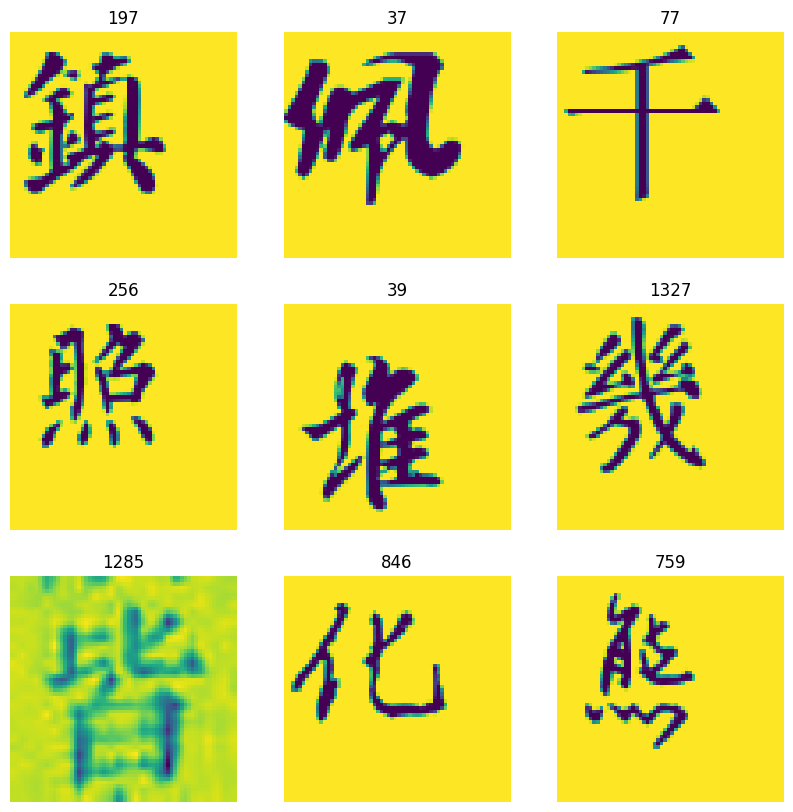

In [19]:
plotter_lib.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plotter_lib.subplot(3, 3, i + 1)
    plotter_lib.imshow(images[i])
    plotter_lib.title(train_dataset.class_names[labels[i]])
    plotter_lib.axis("off")

In [20]:
# Data Shape
for image_batch, labels_batch in train_dataset:
    print(image_batch.shape)
#     print(image_batch[0])
    print(labels_batch.shape)
    break

(64, 64, 64, 1)
(64,)


# Model Define

In [21]:
if TRANFER_LEARNING == True:
    resnet_layer = tf.keras.applications.ResNet50(
        include_top=False,
        weights= 'imagenet',
        input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
        pooling='max',
    )
    # Transfer learning
    count = 0
    for layer in resnet_layer.layers[:FREEZING_RANGE]:
        layer.trainable = False
        count = count+1
    print(count)
else:
    resnet_layer = tf.keras.applications.ResNet50(
        weights = None,
        include_top=False,
        input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], CHANNELS),
        pooling='max',
    )
    # Transfer learning
    count = 0
    for layer in resnet_layer.layers:
        count = count+1
    print(count)
model = Sequential()
if RANDOM_ROTATION == True:
    model.add(RandomRotation(factor=FACTORS))
model.add(Rescaling(1./255))
model.add(resnet_layer)
model.add(Dense(number_of_classes, activation='softmax'))
model.build((None, IMAGE_SIZE[0], IMAGE_SIZE[1], CHANNELS))
model.summary()

176


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_rotation_1               │ (None, 64, 64, 1)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,581,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2130)           │     4,364,370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,945,810 (106.60 MB)

 Trainable params: 27,892,690 (106.40 MB)

 Non-trainable params: 53,120 (207.50 KB)

# Model Compiling

In [22]:
checkpoint_path = "/kaggle/input/model-ver15/resnet_checkpoint.model (1).keras"
# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=5,
    verbose = 1
)

model.compile(
    optimizer=Adam(),
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy']
    )



# Model Training

In [23]:
model.load_weights(checkpoint_path)
history = model.fit(train_dataset, validation_data=validate_dataset, epochs=EPOCH, callbacks=[cp_callback,reduce_lr])

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 430 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


# Plot Result

In [ ]:
plotter_lib.plot(history.history['accuracy'], label='accuracy')
plotter_lib.plot(history.history['val_accuracy'], label = 'val_accuracy')
plotter_lib.xlabel('Epoch')
plotter_lib.ylabel('Accuracy')
plotter_lib.ylim([0, 1])
plotter_lib.legend(loc='lower right')
plotter_lib.show()

# Evaluating on train dataset

In [ ]:
model.evaluate(validate_dataset, verbose=1,batch_size=BATCH_SIZE)

# Saving Model

In [ ]:
model.save('sinonom_resnet.keras')

## Predict on a image folder

In [ ]:
# FOLDER_NAME = "1035"
# images_path = "/kaggle/input/wb-data/wb_recognition_dataset/train/"+FOLDER_NAME
# from tensorflow.keras.preprocessing.image import load_img, img_to_array

# # Specify the directory
# directory = images_path

# # Get a list of all image file names in the directory
# image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

# # Initialize an empty list to hold the image data
# images = []

# # Load each image, convert it to a numpy array, and add it to the list
# for image_file in image_files:
#     img = load_img(os.path.join(directory, image_file), target_size=IMAGE_SIZE)
#     img_array = img_to_array(img)
#     img_array = np.expand_dims(img_array, axis=0)
#     images.append(img_array)

# # Convert the list of image arrays to a single numpy array
# images = np.concatenate(images, axis=0)

# # Normalize the image data

# # Use the model to make predictions
# predictions = model.predict(images)
# predicted_classes = np.argmax(predictions, axis=1)
# print(predicted_classes)
# for i in predicted_classes:
#     print(train_dataset.class_names[i]) 

# Test

In [ ]:
# model = tf.keras.models.load_model('/kaggle/working/sinonom_resnet.keras')
# model.summary()


In [25]:
# model = tf.keras.models.load_model('/kaggle/working/sinonom_resnet.keras')
# Load the CSV file
csv_path = '/kaggle/input/wb-data/wb_recognition_dataset/val/labels.csv'
data = pd.read_csv(csv_path)

# Load the images from the folder
image_folder = '/kaggle/input/wb-data/wb_recognition_dataset/val/images'
image_paths = [os.path.join(image_folder, str(image_name)+".jpg") for image_name in data['image_name']]
images = [tf.keras.preprocessing.image.load_img(image_path,COLOR_MODE,target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1])) for image_path in image_paths]
images = [tf.keras.preprocessing.image.img_to_array(image) for image in images]
images = np.array(images)

# Preprocess the images

# Predict the labels
predictions = model.predict(images)
predicted_labels = [train_dataset.class_names[np.argmax(prediction)] for prediction in predictions]

# Add the predicted labels to the dataframe
data['predicted_label'] = predicted_labels
correct = 0
for i in range(len(data)):
    if str(data['label'][i]) == str(data['label_pred'][i]):
        correct += 1
TEST_ACCURACY = round(correct/len(data), 5)



print("Correct predictions:", correct)
print("Total predictions:", len(data))
print("Accuracy:", TEST_ACCURACY)
# Save the updated dataframe






44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 276ms/step
Correct predictions: 1147
Total predictions: 1392
Accuracy: 0.82399


ValueError: Row is not empty

In [ ]:
import gspread

gc = gspread.service_account(filename='/kaggle/input/helicopter/helical-decoder-382901-2b30ac9f8085.json')

sh = gc.open("resnet_report")
worksheet = sh.get_worksheet(0)
row_index = GSHEET_ROW_INDEX

current_row_values = worksheet.row_values(row_index)
is_empty_row = all(value == '' for value in current_row_values)
if is_empty_row:
    print("adding data to row..")
    TRAIN_ACCURACY = history.history['accuracy'][-1]
    VALIDATION_ACCURACY = history.history['val_accuracy'][-1]
    TEST_ACCURACY = correct/len(data)
    OUTPUTTIME=get_time_string()

    row_data = [IMAGE_SIZE, VALIDATION_SPLIT, TRANFER_LEARNING, FREEZING_RANGE, COLOR_MODE, POOLING, RANDOM_ROTATION, FACTORS, TRAIN_ACCURACY, VALIDATION_ACCURACY, TEST_ACCURACY,OUTPUTTIME]
#     for i, value in enumerate(row_data):
#         worksheet.update_cell(row_index, i+1, str(value))
else:
    raise ValueError("Row is not empty")

In [32]:
OUTPUTTIME=get_time_string()
selected_columns_df = data[['image_name', 'predicted_label']]
selected_columns_df .to_csv("predictions-"+".csv",index=False)